In [1]:
from typing import Dict, Iterable, Optional

import numpy as np
import torch
from torch.distributions import Normal, Poisson
from torch.distributions import kl_divergence as kld
from torch import tensor
from complementary_models import HALOMASKVIR as HALOVI
from complementary_models import HALOMASKVAE as HALOVAE
import scanpy as sc
import scvi

import pandas as pd
# torch.autograd.set_detect_anomaly(True)

Global seed set to 0


In [2]:
### test whole data with RNA only 
path = "data/datasets/S1_Fibroblast.h5ad"
adata_multi = sc.read_h5ad(path)
adata_multi.obs["batch_id"] = 1
adata_multi.var["modality"] =adata_multi.var["feature_types"]
adata_mvi = scvi.data.organize_multiome_anndatas(adata_multi)
sc.pp.filter_genes(adata_mvi, min_cells=int(adata_mvi.shape[0] * 0.01))

In [3]:
adata_mvi.obs

Unnamed: 0     orig.ident  nCount_RNA  \
AAACAGCCAAAGCTCC-1_paired  S1_AAACAGCCAAAGCTCC-1  SeuratProject         514   
AAACAGCCATACCCGG-1_paired  S1_AAACAGCCATACCCGG-1  SeuratProject         708   
AAACCAACAATTATGC-1_paired  S1_AAACCAACAATTATGC-1  SeuratProject        2043   
AAACCGCGTTAACGAT-1_paired  S1_AAACCGCGTTAACGAT-1  SeuratProject         621   
AAACCGGCAACAGGAT-1_paired  S1_AAACCGGCAACAGGAT-1  SeuratProject         680   
...                                          ...            ...         ...   
TTTGACTTCAGGATGA-1_paired  S1_TTTGACTTCAGGATGA-1  SeuratProject        1742   
TTTGCGACAGGTTAAA-1_paired  S1_TTTGCGACAGGTTAAA-1  SeuratProject         670   
TTTGGTGCACCAACCG-1_paired  S1_TTTGGTGCACCAACCG-1  SeuratProject         567   
TTTGTCCCACCCTCAC-1_paired  S1_TTTGTCCCACCCTCAC-1  SeuratProject        2081   
TTTGTTGGTTTGGCGG-1_paired  S1_TTTGTTGGTTTGGCGG-1  SeuratProject         303   

                           nFeature_RNA  nCount_ATAC  nFeature_ATAC Sample  \
AAACAGCCAAAGCTCC-1_paired           342         1113            570     S1   
AAACAGCCATACCCGG-1_paired           426         5571           2786     S1   
AAACCAACAATTATGC-1_paired          1105         5284           2654     S1   
AAACCGCGTTAACGAT-1_paired           386         8741           4292     S1   
AAACCGGCAACAGGAT-1_paired           409         8824           4339     S1   
...                                 ...          ...            ...    ...   
TTTGACTTCAGGATGA-1_paired           883         9079           4481     S1   
TTTGCGACAGGTTAAA-1_paired           429         1429            746     S1   
TTTGGTGCACCAACCG-1_paired           311         6111           3069     S1   
TTTGTCCCACCCTCAC-1_paired          1153         9181           4529     S1   
TTTGTTGGTTTGGCGG-1_paired           203          904            478     S1   

                          Disease_Group  percent.mt  percent.ribo  ...  \
AAACAGCCAAAGCTCC-1_paired   Early Stage   14.007782      1.167315  ...   
AAACAGCCATACCCGG-1_paired   Early Stage    5.649718      0.988701  ...   
AAACCAACAATTATGC-1_paired   Early Stage    5.971610      0.538424  ...   
AAACCGCGTTAACGAT-1_paired   Early Stage    6.441224      1.288245  ...   
AAACCGGCAACAGGAT-1_paired   Early Stage    5.000000      0.882353  ...   
...                                 ...         ...           ...  ...   
TTTGACTTCAGGATGA-1_paired   Early Stage    9.471871      0.631458  ...   
TTTGCGACAGGTTAAA-1_paired   Early Stage    3.731343      1.492537  ...   
TTTGGTGCACCAACCG-1_paired   Early Stage    3.703704      0.881834  ...   
TTTGTCCCACCCTCAC-1_paired   Early Stage    6.054781      0.336377  ...   
TTTGTTGGTTTGGCGG-1_paired   Early Stage    4.950495      2.310231  ...   

                           Doublet_Scores   mouse.main RNA_snn_res.0.2  \
AAACAGCCAAAGCTCC-1_paired        0.049195  Fibroblasts               2   
AAACAGCCATACCCGG-1_paired        0.020735  Fibroblasts               3   
AAACCAACAATTATGC-1_paired        0.076734  Fibroblasts               1   
AAACCGCGTTAACGAT-1_paired        0.037416  Fibroblasts               0   
AAACCGGCAACAGGAT-1_paired        0.021732  Fibroblasts               0   
...                                   ...          ...             ...   
TTTGACTTCAGGATGA-1_paired        0.045896      Neurons               2   
TTTGCGACAGGTTAAA-1_paired        0.017085  Fibroblasts               1   
TTTGGTGCACCAACCG-1_paired        0.119250  Fibroblasts               0   
TTTGTCCCACCCTCAC-1_paired        0.111771  Fibroblasts               1   
TTTGTTGGTTTGGCGG-1_paired        0.040949  Fibroblasts               2   

                           seurat_clusters  RNA_snn_res.0.3  CytoTRACE  \
AAACAGCCAAAGCTCC-1_paired                4                4   0.860806   
AAACAGCCATACCCGG-1_paired                7                7   0.746337   
AAACCAACAATTATGC-1_paired                1                1   0.774725   
AAACCGCGTTAACGAT-1_paired                1                1   0.195055   
AAAC

In [4]:
HALOVI.setup_anndata(adata_mvi, batch_key="modality", time_key='monocle3_pseudotime')
model = HALOVI(
    adata_mvi,
    n_genes=(adata_mvi.var['modality']=='Gene Expression').sum(),
    n_regions=(adata_mvi.var['modality']=='Peaks').sum()
)

n_genes :9407
fine tune is False
gate decoder initialization n_input 10, n_output 65647,         n_hidden_local 20, n_hidden_global 128, n_cat_list [1], *cat_list 1


In [5]:
## load pre-trained models
model = model.load("model_s1_fibroblast_nocausal", adata_mvi)
# model = model.load("model_A594_causal03", adata_mvi)

# model = model.load("model_hair_nocausal", adata_mvi)


INFO     File model_s1_fibroblast_nocausal/model.pt already downloaded                       
n_genes :9407
fine tune is False
gate decoder initialization n_input 10, n_output 65647,         n_hidden_local 20, n_hidden_global 128, n_cat_list [1], *cat_list 1


In [19]:
model.module.set_finetune_params(0)
model.module.set_train_params(expr_train=True, acc_train=True)
model.train(max_epochs=1000, batch_size=256)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1933: PossibleUserWarning: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 1000/1000: 100%|██████████| 1000/1000 [07:33<00:00,  2.21it/s, loss=4.44e+04, v_num=1]


In [20]:
# model.save("model_myeloid_data_nocausal",overwrite=True)
model.save("model_s1_fibroblast_nocausal",overwrite=True)

In [8]:
model.module.alpha = 0.025
model.module.beta_2 = 1e6
model.module.beta_3 = 1e6
model.module.beta_1 = 1e6
print(model.module.alpha)

0.025


In [9]:
## finetune without L0
# model.module.alpha = 0.06
model.module.set_finetune_params(2)
model.module.set_train_params(expr_train=True, acc_train=True)
model.plan_kwargs = {"n_epochs_kl_warmup":300}
model.train(max_epochs=1000, batch_size=1000)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1933: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 1/1000:   0%|          | 0/1000 [00:00<?, ?it/s]reconst_loss tensor([ 14253.2324,  70287.4297,  44935.0312, 101312.1406,  59753.2305,
         30421.9336,  42547.1719,  79586.7109,  29607.0312,  42884.6484,
         33387.5742,  35545.0547,  45541.1055,  53430.6562,  27823.7910,
         50098.3125,  23664.4375,  56482.0859,  72605.4844,  69846.8594,
         42141.8242,  49815.7148,  32602.8438,  57715.2500,  40488.0742,
         45770.3203,  64291.1094,  64108.3828,  73661.8359,  40493.7695,
         43693.4414,  31234.7383,  24768.6582,  18468.2148,  21026.6914,
         49106.8398,  85342.4219,  36912.9531,  28902.0352,  46861.8359,
         58746.8242,  27038.7617,  53791.3516,  54098.5312,  20863.6914,
         23990.9727,  36393.5312,  18539.7070,  36752.3945,  54188.3945,
         14210.0176,  15973.9219,  54543.8594,  55242.1719,  12591.4521,
         30624.8535,  20737.5039,  67079.4844,  12590.8516,   9363.6318,
         27715.5879,  44874.0703,  48573.4023,  61333.781

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:726: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [20]:
model.save("model_S1_fibroblast_causal0025",overwrite=True)

In [5]:
# model = model.load("model_A594_causal01", adata_mvi)
# model = model.load("model_A549_nocausal", adata_mvi)
model = model.load("model_S1_fibroblast_causal0025", adata_mvi)

# model = model.load("model_A594_causal015", adata_mvi)
# model = model.load("model_A594_causal005", adata_mvi)

INFO     File model_S1_fibroblast_causal0025/model.pt already downloaded                     
n_genes :9407
fine tune is False
gate decoder initialization n_input 10, n_output 65647,         n_hidden_local 20, n_hidden_global 128, n_cat_list [1], *cat_list 1


In [11]:
latent_expr, latent_acc,latent_expr_dep, latent_atac_dep, latent_expr_indep, latent_atac_indep, times  = model.get_latent_representation()

In [12]:
from complementary_models import torch_infer_nonsta_dir
from complementary_models import torch_infer_nonsta_dir

In [13]:
latent_atac_indep_t = torch.tensor(latent_atac_indep).to('cuda')
latent_expr_indep_t = torch.tensor(latent_expr_indep).to('cuda')
times = torch.tensor(times).to('cuda')

# times = np.array(times.detach().cpu())
score3 = []
score4=[]

latent_atac_dep_t = torch.tensor(latent_atac_dep).to('cuda')
latent_expr_dep_t = torch.tensor(latent_expr_dep).to('cuda')

score1 = []
score2=[]
sample_num = 700
iterations = 30

for i in range(iterations):
    index = np.random.choice(latent_acc.shape[0] , sample_num)
    score3.append(torch_infer_nonsta_dir(latent_atac_indep_t[index,:], latent_expr_indep_t[index,:], times[index])[0].detach().cpu())
    score4.append(torch_infer_nonsta_dir(latent_expr_indep_t[index,:], latent_atac_indep_t[index,:], times[index])[0].detach().cpu())
    score1.append(torch_infer_nonsta_dir(latent_atac_dep_t[index,:], latent_expr_dep_t[index,:], times[index])[0].detach().cpu())
    score2.append(torch_infer_nonsta_dir(latent_expr_dep_t[index,:], latent_atac_dep_t[index,:], times[index])[0].detach().cpu())


score3 = np.array(score3)
score4 = np.array(score4)
# print("score3: {}".format(score3))
# print("score4: {}".format(score4))
print("score3 :{}, score4: {}, Delta :{}".format(np.mean(score3), np.mean(score4), np.mean(score3) - np.mean(score4)))

score1 = np.array(score1)
score2 = np.array(score2)

# print("score1: {}".format(score1))
# print("score2: {}".format(score2))
print("score1 :{}, score2: {}, Delta :{}".format(np.mean(score1), np.mean(score2), np.mean(score1) - np.mean(score2)))



score3 :0.022326847038758976, score4: 0.02241873719146849, Delta :-9.189015270951589e-05
score1 :0.024606064935140174, score2: 0.025621569738433225, Delta :-0.0010155048032930505


## nocausal results

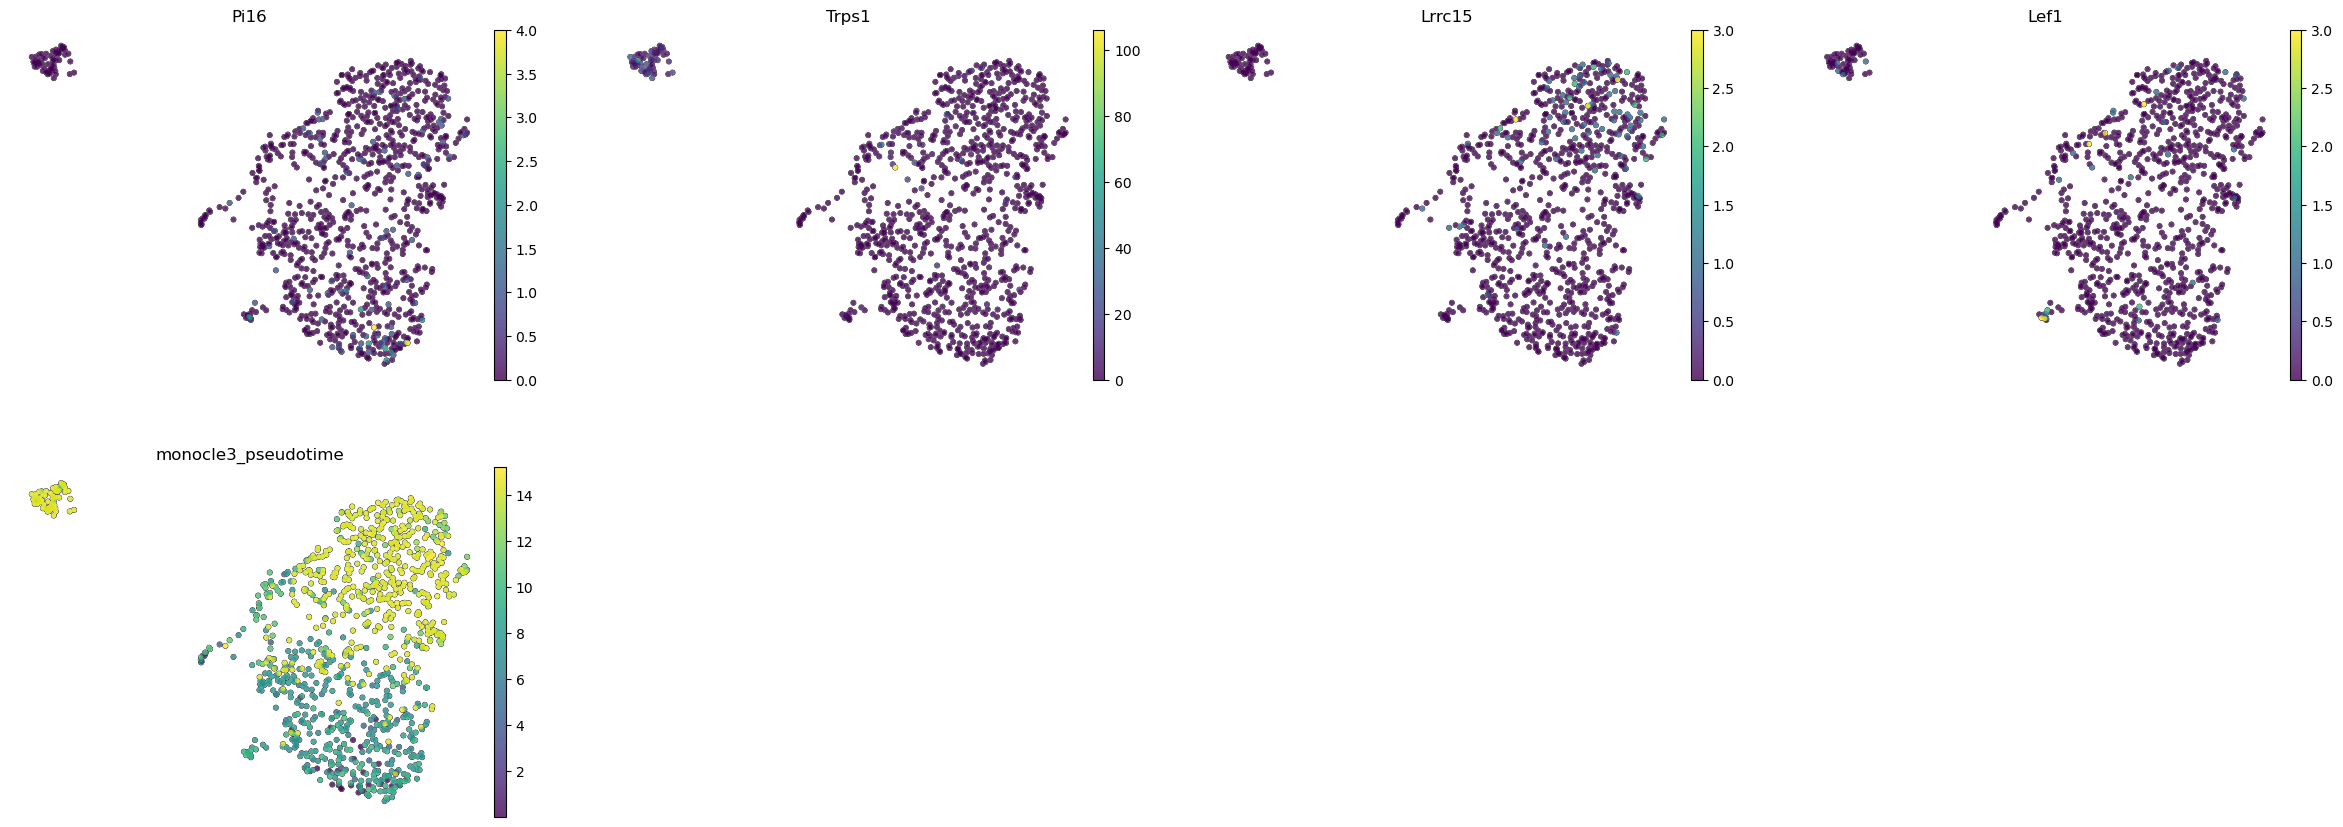

In [26]:

adata_mvi.obsm["latent"] = latent_expr
# sc.pp.neighbors(adata_mvi, use_rep = 'latent', metric = 'manhattan')
sc.pp.neighbors(adata_mvi, use_rep = 'latent')

sc.tl.umap(adata_mvi, min_dist=0.1)

sc.pl.umap(adata_mvi, frameon=False, size = 50, alpha = 0.8, add_outline=True,
          outline_width=(0.1,0), color=["Pi16", "Trps1", "Lrrc15", "Lef1",'monocle3_pseudotime'])

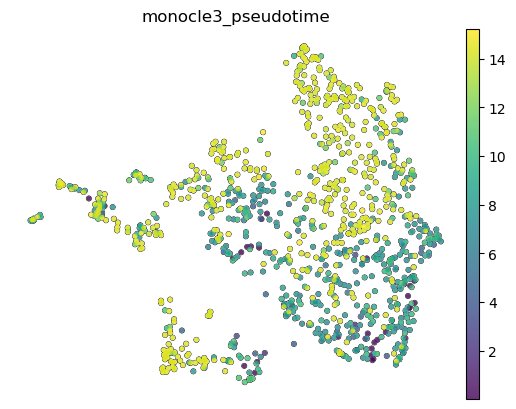

In [23]:
adata_mvi.obsm["latent"] = latent_acc
# sc.pp.neighbors(adata_mvi, use_rep = 'latent', metric = 'manhattan')
sc.pp.neighbors(adata_mvi, use_rep = 'latent')

sc.tl.umap(adata_mvi, min_dist=0.1)

sc.pl.umap(adata_mvi, frameon=False, size = 50, alpha = 0.8, add_outline=True,
          outline_width=(0.1,0), color=["monocle3_pseudotime"])

## Causal representations


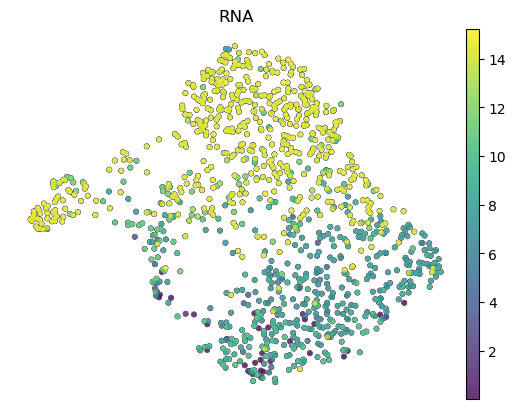

In [14]:
import seaborn as sns
adata_mvi.obsm["latent"] = latent_expr
# sc.pp.neighbors(adata_mvi, use_rep = 'latent', metric = 'manhattan')
sc.pp.neighbors(adata_mvi, use_rep = 'latent')

sc.tl.umap(adata_mvi, min_dist=0.2)

# sc.pl.umap(adata_mvi, frameon=False, size = 50, alpha = 0.8, add_outline=True,
#           outline_width=(0.1,0), color=["treatment_time"], title="RNA",  cmap=sns.blend_palette(["lightgray", sns.xkcd_rgb["blood"]], as_cmap=True))


sc.pl.umap(adata_mvi, frameon=False, size = 50, alpha = 0.8, add_outline=True,
          outline_width=(0.1,0), color=["monocle3_pseudotime"], title="RNA")

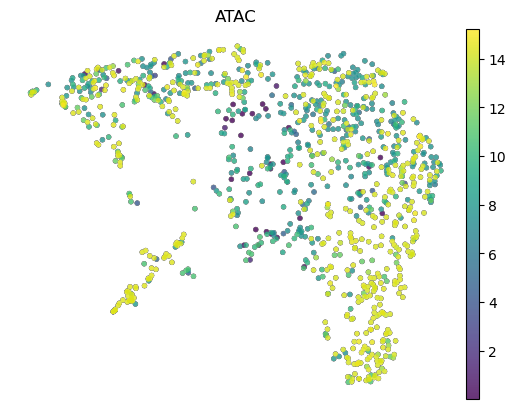

In [15]:
adata_mvi.obsm["latent"] = latent_acc
sc.pp.neighbors(adata_mvi, use_rep = 'latent',n_neighbors=15)
sc.tl.umap(adata_mvi, min_dist=0.1)

sc.pl.umap(adata_mvi, frameon=False, size = 50, alpha = 0.8, add_outline=True,
          outline_width=(0.05,0), color=["monocle3_pseudotime"], title="ATAC")

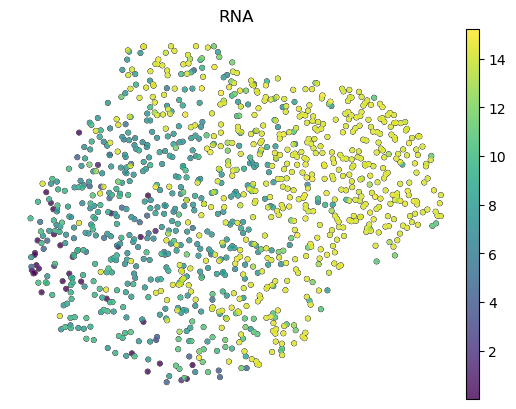

In [16]:
adata_mvi.obsm["latent"] =latent_expr_dep
sc.pp.neighbors(adata_mvi, use_rep="latent")



sc.tl.umap(adata_mvi,min_dist =0.5)
%matplotlib inline
# sc.pl.umap(adata_mvi,color=["treatment_time"], s=50, alpha = 0.8, frameon=False, ncols=2, vmax='p99', title="RNA coupled",  cmap=sns.blend_palette(["lightgray", sns.xkcd_rgb["blood"]],as_cmap=True))

sc.pl.umap(adata_mvi, frameon=False, size = 50, alpha = 0.8, add_outline=True,
          outline_width=(0.1,0), color=["monocle3_pseudotime"], title="RNA")

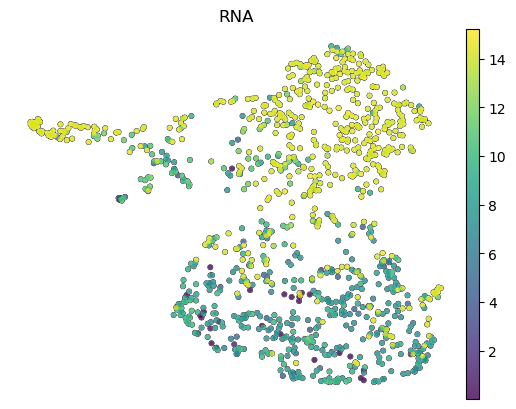

In [17]:
adata_mvi.obsm["latent"] =latent_expr_indep
sc.pp.neighbors(adata_mvi, use_rep="latent")
sc.tl.umap(adata_mvi,min_dist =0.1)

%matplotlib inline
# 
sc.pl.umap(adata_mvi, frameon=False, size = 50, alpha = 0.8, add_outline=True,
          outline_width=(0.1,0), color=["monocle3_pseudotime"], title="RNA")


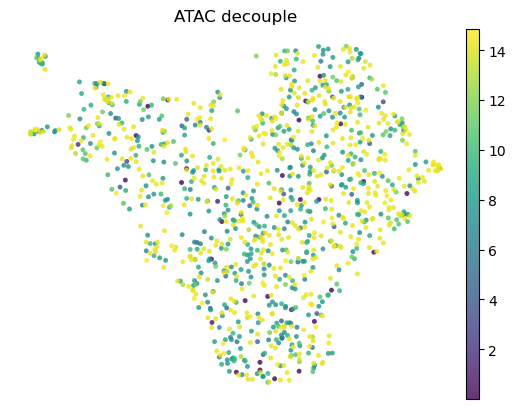

In [18]:
adata_mvi.obsm["latent"] =latent_atac_indep
sc.pp.neighbors(adata_mvi, use_rep="latent")

sc.tl.umap(adata_mvi,min_dist =0.3)

sc.pl.umap(adata_mvi,color=["monocle3_pseudotime"], s=50, frameon=False, ncols=2, vmax='p99', title="ATAC decouple", alpha = 0.8)


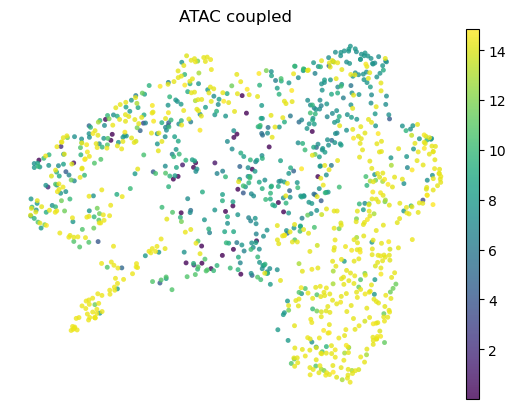

In [19]:
adata_mvi.obsm["latent"] =latent_atac_dep
sc.pp.neighbors(adata_mvi, use_rep="latent")

sc.tl.umap(adata_mvi,min_dist =0.3)

sc.pl.umap(adata_mvi,color=["monocle3_pseudotime"], s=50, frameon=False, ncols=2, vmax='p99', title="ATAC coupled", alpha = 0.8)

